# Two-layer flow over topography

This assignment involves simulations of two-layer flow over topography. There are two distinct parts: unidirectional flow and exchange flow. Input files for simulations are created with `./gendata.py`. All have the same dimensions and use a gaussian bump. Differences between simulation depend on the non-dimensional thickness of the lower layer ($r$), the non-dimensional bump height ($H_m$), and the initial Froude number.

# MITgcm analysis tools 

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from scipy.ndimage.filters import gaussian_filter1d
from xmitgcm import open_mdsdataset
from MyFunctions import get_contour
from MyMITgcmUtils import mask_mitgcm_output
# Ignore warnings from xmitgcm
warnings.filterwarnings('ignore',".*Couldn't find available_diagnostics.log*.")
warnings.filterwarnings('ignore',".*Not sure what to do with rlev = L*.")
os.chdir('/home/hugke729/mitgcm/stratified_flow_directed_study/'
         'two_layer_topography_proj4/')

%matplotlib inline


def plot_exp_mitgcm(run_name, Nt=-1, t_slice=np.s_[:], xlim=None,
                    interface_offset=1, interface_sigma=0):
    """Display initial conditions, a waterfall plot of the interface, and
    the value of G(x) at four different times"""
    fig, axs = plt.subplots(ncols=3, sharex=True, figsize=(10, 3.5))

    run_dir = './runs/' + str(run_name)
    ds = open_mdsdataset(run_dir, prefix=['T', 'U'], delta_t=60).squeeze()
    x_km = ds.XC/1e3
    
    # Despite using layers with temps of 10 and 15, the interface seems to be
    # better represented by the 13.5 isotherm, not the 12.5 isotherm
    Tinterface = 13.5 

    with open(run_dir + '/summary.txt', 'rt') as f:
        fig.suptitle(f.read().rstrip('\n'))

    def get_G():
        """Get composite froude number for current time step"""
        lower_layer = (ds.Z.values < interface[:, np.newaxis]).T
        upper_layer = ~lower_layer
        below_seafloor = -ds.Z.values[:, np.newaxis] > ds.Depth.values
        lower_layer = np.logical_and(lower_layer, ~below_seafloor)

        U = ds.U.isel(time=i).values
        U_lower = ma.mean(ma.masked_where(~lower_layer, U), axis=0)
        U_upper = ma.mean(ma.masked_where(~upper_layer, U), axis=0)

        lower_thickness = ds.Depth + interface
        upper_thickness = -interface

        gprime = 1E-3*9.81  # reduced gravity from gendata.py

        Fr_upper_sq = U_upper**2/(gprime*upper_thickness)
        Fr_lower_sq = U_lower**2/(gprime*lower_thickness)

        G = np.sqrt(Fr_lower_sq + Fr_upper_sq)

        colors = 'rbgk'
        axs[2].axhline(Goffset + 1, ls='--', color=colors[Goffset])
        axs[2].plot(x_km, G + Goffset, color=colors[Goffset])
        axs[2].fill_between(x_km, G + Goffset, Goffset + 1, color=colors[Goffset],
                            alpha=0.3, where=G>1)

        return G

    Goffset = 0
    for i, t_i in enumerate(ds.time[:Nt][t_slice]):
        interface = get_contour(x_km, ds.Z, ds['T'].isel(time=i).values,
                                Tinterface)
        interface = gaussian_filter1d(interface, interface_sigma)
        axs[1].plot(x_km, interface + interface_offset*i, color='k')
        axs[1].set(yticks=[], xlabel='Distance (km)')
        axs[0].set(ylim=(-np.max(ds.Depth), 0), xlim=x_km[[0, -1]],
                   title='Initial Interface',
                   xlabel='Distance (km)')
        axs[1].set_title('Evolution with time')
        axs[2].set_title('G at iterations 1, 2, 4, and 6\n'
                         '(offset and shaded where supercritical)')

        if i == 0:
            axs[0].fill_between(x_km, interface, -ds.Depth, color='lightgrey')
            axs[0].plot(x_km, -ds.Depth, color='k')
            axs[0].plot(x_km, interface, color='grey')
            U0 = ds['U'].isel(time=i)
            j = np.where(x_km > 50)[0][0]
            z_ones = np.ones_like(ds.Z[::5])
            if run_name[:3] == 'uni':
                axs[0].quiver(x_km.values[j, np.newaxis]*z_ones, ds.Z[::5],
                              U0[::5, j], 0*z_ones)
                axs[0].set_title('Interface and initial velocities')

        if i in [1, 2, 4, 6]:
            get_G()
            Goffset += 1
    x_peak = x_km[np.argmin(ds.Depth.values) + 1]
    [ax.axvline(x_peak, color='grey', ls='--') for ax in axs]

    if xlim is not None:
        axs[0].set(xlim=xlim)


# Exchange flow

I simulate an exchange flow over a Gaussian bump extending 60% up the water column with dense water on the left side that extends above the bump to three different heights.

In two of the experiments, with initial dense water thicknesses of 70% and 80%, the flow behaves in large part like a single layer flow. Although the upper layer accelerates to the left, it is the lower layer that is controlled, and the composite Froude number is unity at the sill and >1 downstream of it until it undergoes an internal hydraulic jump.

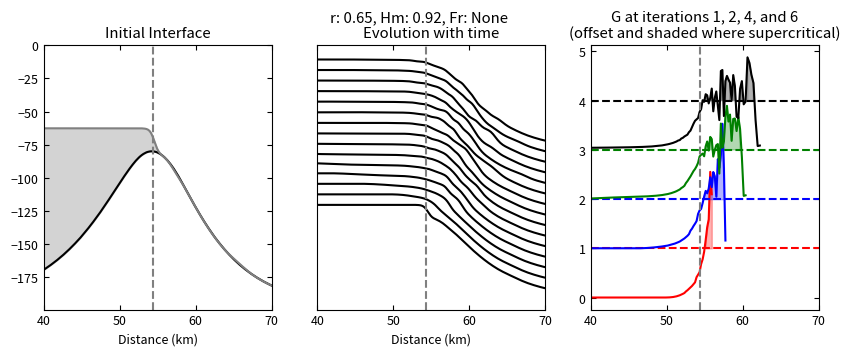

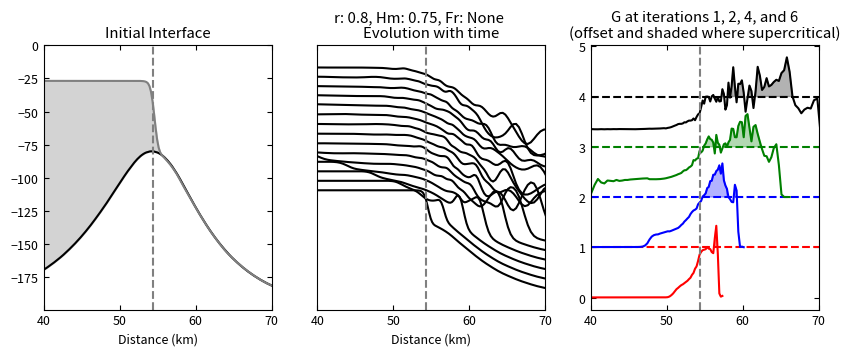

In [13]:
exc_plot_opts = dict(xlim=(40, 70), interface_offset=15, interface_sigma=2)
plot_exp_mitgcm('exc1', **exc_plot_opts)
plot_exp_mitgcm('exc2', **exc_plot_opts)

The experiments above are examples of controlled, but submaximal exchange. This can be identified by the presence of only one control point, the sill crest. 

Alternatively, if the dense reservoir is sufficiently thick, maximal exchange is achieved:

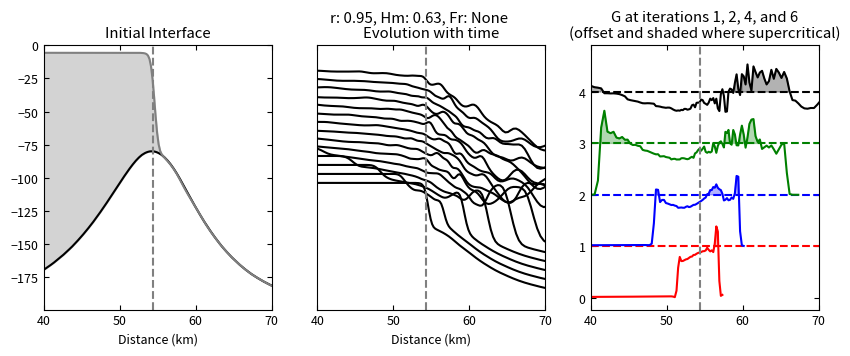

In [14]:
plot_exp_mitgcm('exc3', **exc_plot_opts)

Although the evolution of the interface appears similar, the evolution of $G(x)$ is distinctly different. There now exists two control points, one at the sill and one to the left of the sill. Between these, the flow is subcritical. Such a condition is necessary for stability (Zhu, 2003, doi:10.1080/00221680309499995).

In this simulation, the left-hand control location moves away from the sill. This occurs because the simulation is not in a steady state. Given sufficient time and appropriate reservoir conditions, I would expect the left-hand control location to stay at a fixed point, but I have not attempted to do this in my simulation.

# Unidirectional flow

## Transient response
Most simulations have been set up such that partial upstream blocking occurs. To explain the transient behaviour and set up of critical conditions, I first consider a relatively simple example: thin lower layer with medium bump.

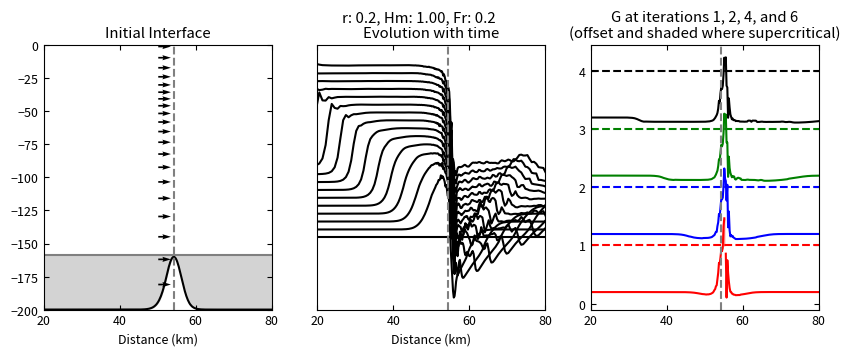

In [16]:
plot_exp_mitgcm('uni_r_0p2_Hm_1_Fr_0p2', xlim=(20, 80))

In this example, the mean current speed is slow compared to the internal wave speed (Fr = 0.2). The bump, however, is large and induces an internal hydraulic control.

Consider first the upstream part of the flow. Because of the bump, the flow in the lower layer is blocked and accumulates upstream of the obstacle raising the level of the interface just upstream of the crest. This perturbation of the interface can travel upstream because it can travel faster than the current that opposes it. The lower layer, however, continues to flow toward the obstacle and continues to raise the level of the interface just upstream of the bump. The result is an upstream-propagating bore. 

The height of the bore is limited by conditions at the crest. Specifically, the composite Froude number = 1. This is evident from the experiment if we zoom in (see figure below). Note that the value of $G$ is unity at the crest of the sill at 54 km. If the lower layer at the crest were thinner, then not enough lower-layer fluid would flow out over the crest. Instead, it would accumulate behind the obstacle and raise the interface level.

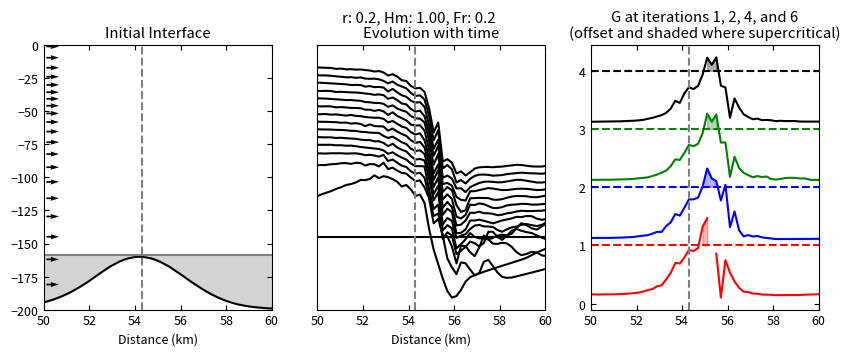

In [17]:
plot_exp_mitgcm('uni_r_0p2_Hm_1_Fr_0p2', xlim=(50, 60))

### Response with a faster lower layer

If we repeat the experiment above, but with a faster lower layer (Fr = 0.8, not 0.2), a much larger jump is observed. Reading jump heights off the contours in Figure 3.12b of Baines (1995), I would expect jump heights of approximately 20% of the lower layer thickness for Fr = 0.2, and 90% of the lower layer thickness for Fr = 0.8. In my simulations, I find values of 25% (10m jump above 40m thick lower layer) and 100% (80m jump), i.e., good agreement with YG jump formulation considering uncertainty in reading off contours.

As for the jump speed, comparison of the simulations shows that the jump in the Fr = 0.2 case clearly travels further upstream during the simulation. Again, this is consistent with Figure 3.12b. The value of $(c_j - U)/c_0$ for Fr = 0.2 case is 0.8, but for the Fr = 0.8 case it is only 0.45.

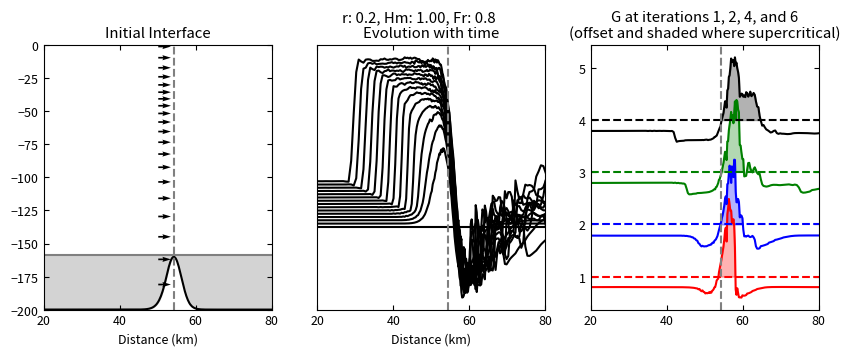

In [4]:
plot_exp_mitgcm('uni_r_0p2_Hm_1_Fr_0p8', xlim=(20, 80))

### Response with a thicker lower layer

If we repeat the first experiment described above but with $r = $ 0.5 (not 0.2), we find much the same behaviour. A subtle difference, however, is that the upstream-propagating disturbance is less bore-like. As the lower layer thickens above the halfway depth, its velocity decreases with increasing thickness. Therefore, the downstream parts of the wave cannot "catch up" with the front of the wave.

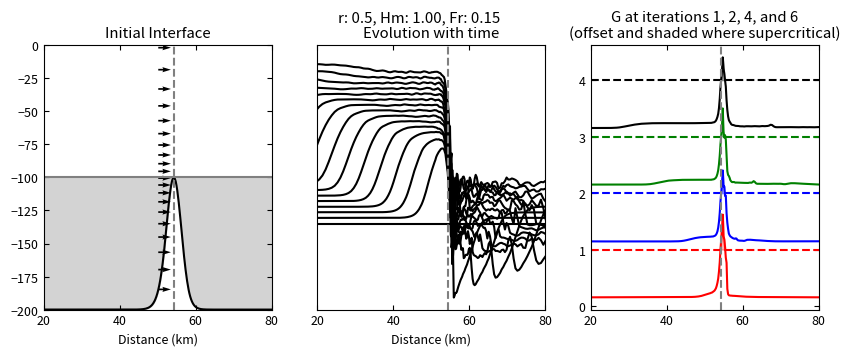

In [18]:
plot_exp_mitgcm('uni_r_0p5_Hm_1_Fr_0p15', xlim=(20, 80))

## Approach control

In general, flow can smoothly transition from subcritical to supercritical where $\mathrm{d}h/\mathrm{d}x$ = 0 (where $h$ is the seafloor depth). In most cases, this is the sill crest. However, for two-layer flow, there exists a potential alternative termed an approach control. In this situation, the transition still occurs where $\mathrm{d}h/\mathrm{d}x$ = 0, but this is now at the upstream edge of the topography and is somewhat time dependant. That is, the transition about $G^2 = 1$ moves upstream with time. Also obsered in such flows is a rarefaction upstream.

I observed an approach control in one of my experiments ($r = 0.5, H_m = 1, \mathrm{Fr_0} = 0.8$). Zooming in on the obstacle shows the that the transition to supercritical moves upstream with time.

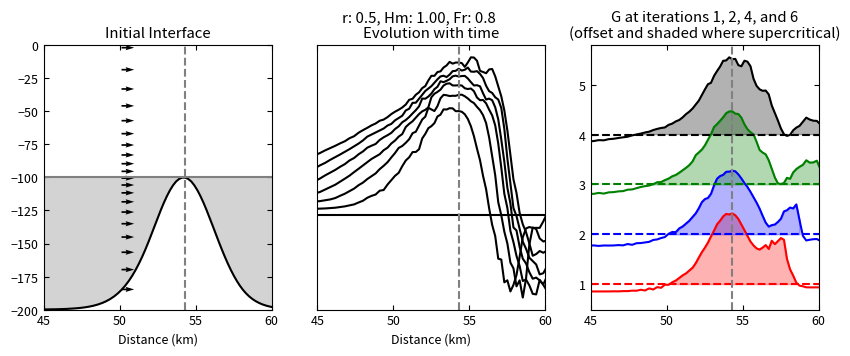

In [21]:
plot_exp_mitgcm('uni_r_0p5_Hm_1_Fr_0p8', xlim=(45, 60), t_slice=np.s_[:7], interface_offset=3)

## All unidrectional simulations for reference

Qualitatively, the behaviour of controlled solutions is little different from one of the situations described above. 

One interesting difference, however, is shown in the last experiment below ($r = 0.8, H_m = 0.25, \mathrm{Fr} = 0.8$). With the thick lower layer, we still have $G=1$ at the crest, but the supercritical portion lies upstream not downstream.

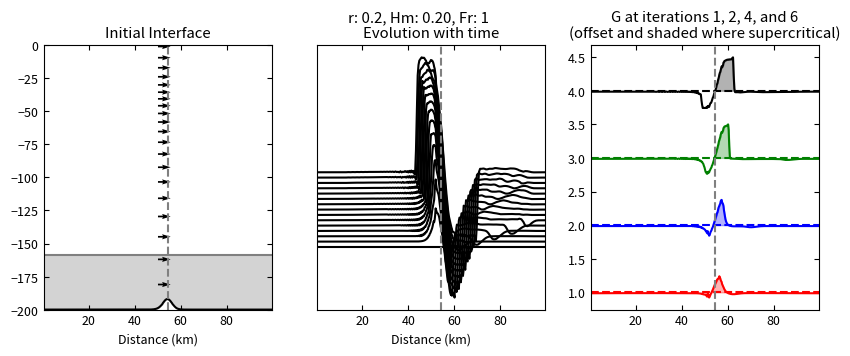

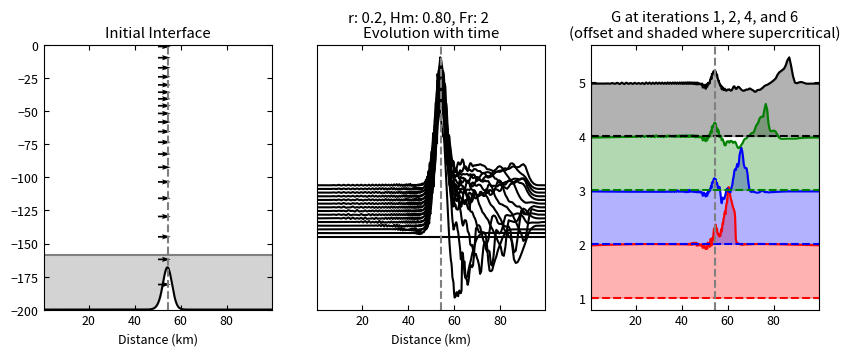

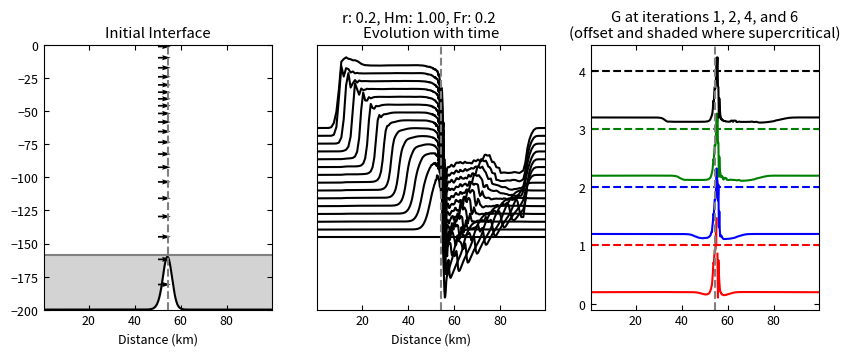

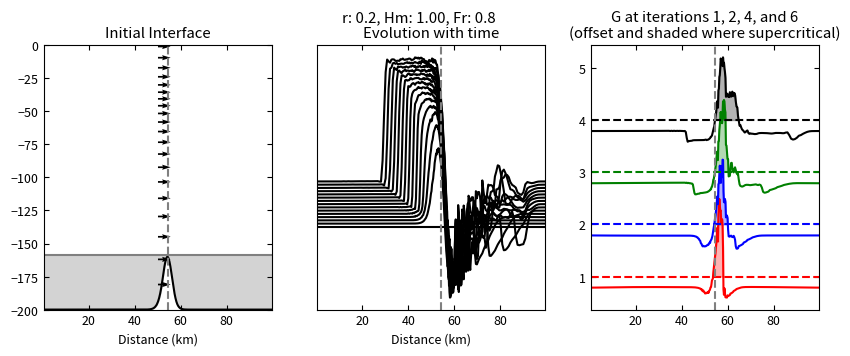

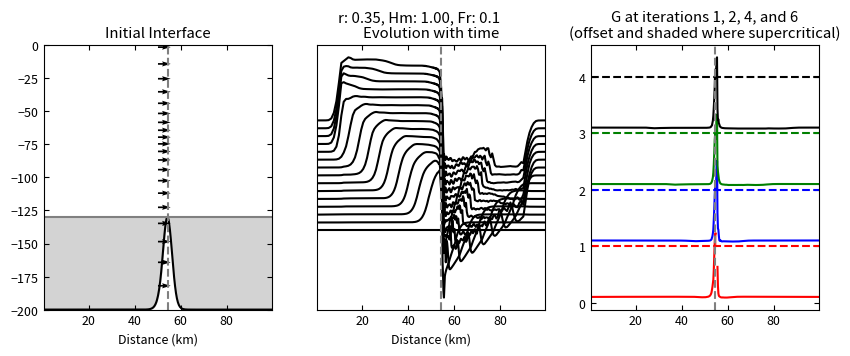

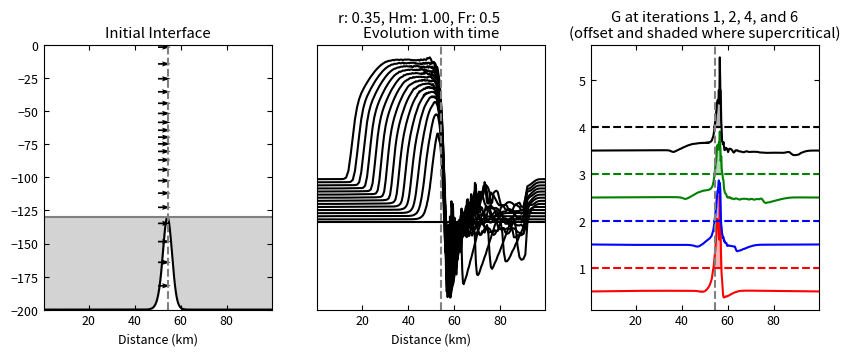

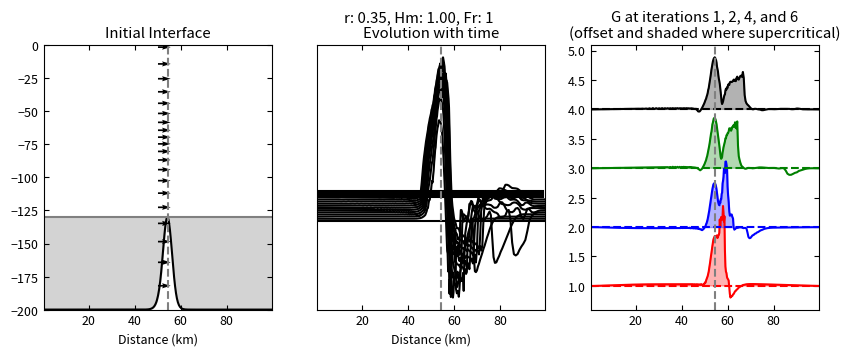

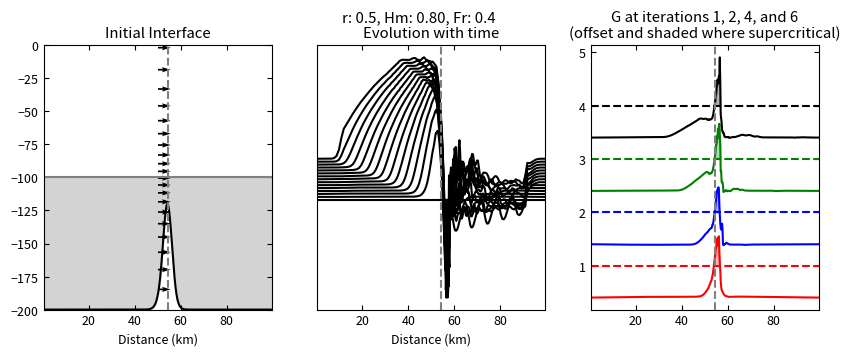

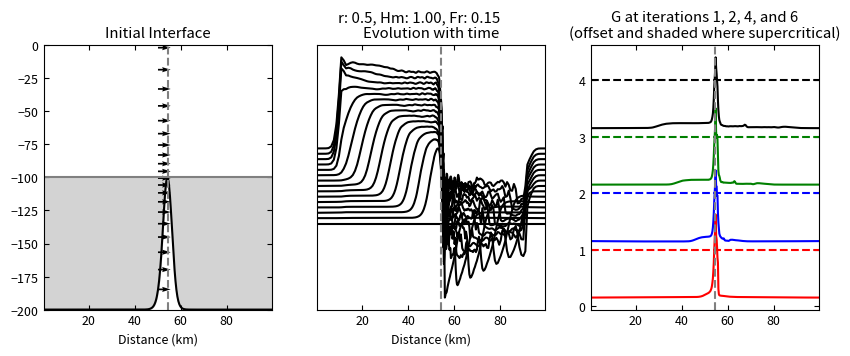

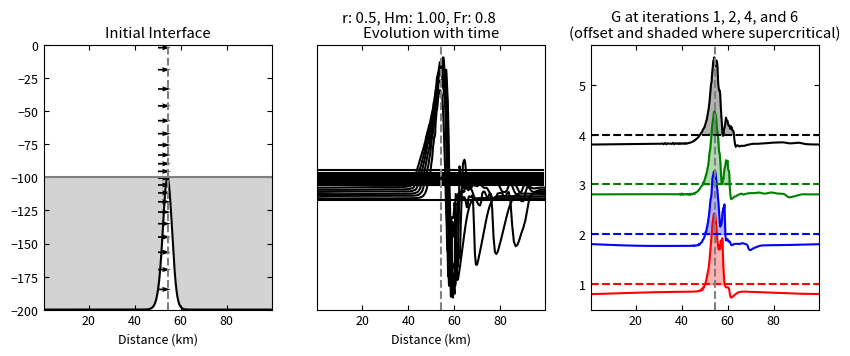

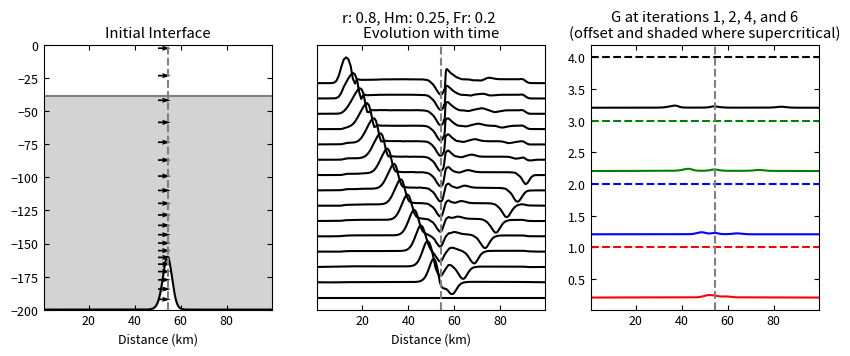

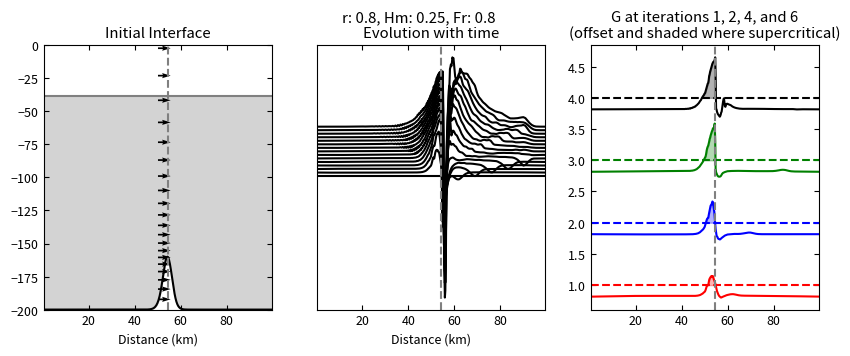

In [9]:
plot_exp_mitgcm('uni_r_0p2_Hm_0p2_Fr_1')
plot_exp_mitgcm('uni_r_0p2_Hm_0p8_Fr_2')
plot_exp_mitgcm('uni_r_0p2_Hm_1_Fr_0p2')
plot_exp_mitgcm('uni_r_0p2_Hm_1_Fr_0p8')
plot_exp_mitgcm('uni_r_0p35_Hm_1_Fr_0p1')  
plot_exp_mitgcm('uni_r_0p35_Hm_1_Fr_0p5')   
plot_exp_mitgcm('uni_r_0p35_Hm_1_Fr_1')
plot_exp_mitgcm('uni_r_0p5_Hm_0p8_Fr_0p4')
plot_exp_mitgcm('uni_r_0p5_Hm_1_Fr_0p15')
plot_exp_mitgcm('uni_r_0p5_Hm_1_Fr_0p8')
plot_exp_mitgcm('uni_r_0p8_Hm_0p25_Fr_0p2')
plot_exp_mitgcm('uni_r_0p8_Hm_0p25_Fr_0p8')